# Early Flagging of Misleading X Posts: Machine Learning Methods

#### Importing modules

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import time

# Preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Word embedding
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


# Download required NLTK resources
# nltk.data.path.append("/Users/bastian/nltk_data")
# nltk.download()
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
nltk.download('wordnet')
# nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/rj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Data loading and preprocessing

In [2]:
import pickle

with open('filtered_data.pkl', 'rb') as f:
    pickle_dict = pickle.load(f)

In [3]:
X = pickle_dict['X']
X_notes = pickle_dict['X_notes']
y = pickle_dict['y']

In [4]:
# Text preprocessing and language detection functions
def preprocess_text(text, language='english'):
    """
    Preprocess text with the following steps:
    1. Lowercase conversion
    2. Remove URLs, special characters, and numbers
    3. Tokenization
    4. Remove stopwords
    Returns: Preprocessed tokens
    """
    # Remove newlines first
    text = text.replace('\n', ' ')

    # 1. Convert to lowercase
    text = text.casefold()
    
    # 2. Remove URLs, special characters, and numbers
    text = re.sub(r'https?://\S+|www\.\S+', '[LINK]', text)  # URLs
    text = re.sub(r'(?<!\[LINK\])[^a-zA-Z\s]', ' ', text)  # Non-alphabetic characters
    text = re.sub(r'\d+', '', text)  # Numbers
    
    # 3. Tokenize text
    tokens = word_tokenize(' '.join([word for word in text.split() if word != '[LINK]']))
    
    # 4. Remove stopwords
    stop_words = set(stopwords.words(language))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

In [5]:
preproced_dict = {}
for key in pickle_dict.keys():
    if key.startswith('y'):
        preproced_dict[key] = pickle_dict[key]
    else:
        preproced_dict[key] = [preprocess_text(text) for text in pickle_dict[key]]

In [7]:
# Calculate time to do preprocessing, will be added to inference time according to test data size

start_time = time.time()
X_post_preproc = [preprocess_text(i) for i in X]
end_time = time.time()
print(f"Time taken for all data: {round(end_time - start_time, 2)} seconds")
print(f"Time taken per tweet: {round((end_time - start_time) * 1000 / len(X), 2)} milliseconds")
# X_post_test = [preprocess_text(i) for i in X_post_test]

Time taken for all data: 6.9 seconds
Time taken per tweet: 0.14 milliseconds


#### BoW + SVM

Time taken to vectorize: 0.7420148849487305 seconds
Time taken to predict: 28.005390882492065 seconds


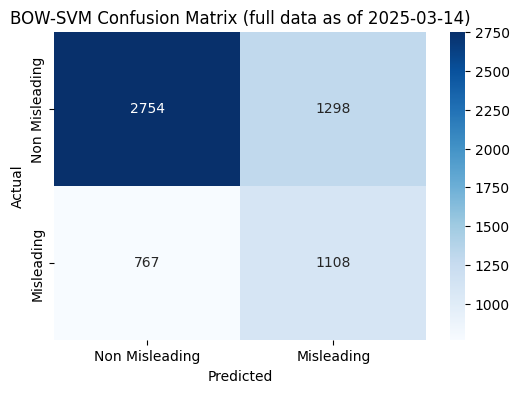

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      4052
           1       0.46      0.59      0.52      1875

    accuracy                           0.65      5927
   macro avg       0.62      0.64      0.62      5927
weighted avg       0.68      0.65      0.66      5927

F1 Score: 51.76%
Time taken to vectorize and predict: 28.747405767440796 seconds


In [8]:
vectorizer = CountVectorizer()

start_time = time.time()
X_bow = vectorizer.fit_transform([" ".join(tweet) for tweet in preproced_dict['X']]) #ini buat bikin bag of words dari tweet yang udah di process
end_time = time.time()

vectorizer_time = end_time - start_time
print(f"Time taken to vectorize: {round(vectorizer_time, 2)} seconds")

X_train_bow, X_temp_bow, y_train_bow, y_temp_bow = train_test_split(X_bow, preproced_dict['y'], test_size=0.2, random_state=42)
X_val_bow, X_test_bow, y_val_bow, y_test_bow = train_test_split(X_temp_bow, y_temp_bow, test_size=0.6, random_state=42)

#SVM model with weighted classes balanced
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train_bow, y_train_bow)

start_time = time.time()
y_pred = svm_model.predict(X_test_bow)
end_time = time.time()

predict_time = end_time - start_time
print(f"Time taken to predict: {round(predict_time, 2)} seconds")

accuracy = accuracy_score(y_test_bow,y_pred)
cm = confusion_matrix(y_test_bow,y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Misleading", "Misleading"], yticklabels=["Non Misleading", "Misleading"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'BOW-SVM Confusion Matrix (full data as of 2025-03-14)')
plt.show()

print(classification_report(y_test_bow, y_pred))
print("F1 Score: {:.2f}%".format(f1_score(y_test_bow, y_pred) * 100))
print(f"Time taken to vectorize and predict: {round(vectorizer_time + predict_time, 2)} seconds")

model_name = "BOW + SVM"
accuracy = accuracy_score(y_test_bow, y_pred) * 100
precision = precision_score(y_test_bow, y_pred, pos_label=1) * 100  # Misleading is class 1
recall = recall_score(y_test_bow, y_pred, pos_label=1) * 100
f1 = f1_score(y_test_bow, y_pred, pos_label=1) * 100

# # Append to results
# results.append({
#     "Model Name": model_name,
#     "Accuracy": accuracy,
#     "Precision": precision,
#     "Recall": recall,
#     "F1-Score": f1
# })

#### TF-IDF + SVM

Time taken to vectorize: 0.8 seconds
Time taken to predict: 33.56 seconds


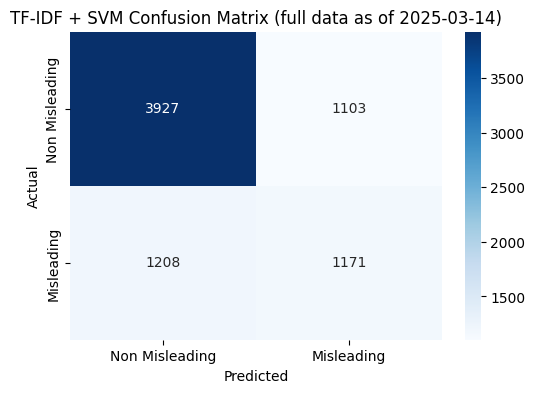

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      5030
           1       0.51      0.49      0.50      2379

    accuracy                           0.69      7409
   macro avg       0.64      0.64      0.64      7409
weighted avg       0.68      0.69      0.69      7409

F1 Score: 50.33%
Time taken to vectorize and predict: 34.36 seconds


In [9]:
vectorizer2 = TfidfVectorizer()

start_time = time.time()
X_tfidf = vectorizer2.fit_transform([" ".join(tweet) for tweet in preproced_dict['X']])
end_time = time.time()
vectorizer_time = end_time - start_time
print(f"Time taken to vectorize: {round(vectorizer_time, 2)} seconds")

X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(X_tfidf, preproced_dict['y'], test_size=0.25, random_state=42)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(X_temp_tfidf, y_temp_tfidf, test_size=0.6, random_state=42)

svm_model = SVC(kernel = 'rbf',class_weight='balanced')
svm_model.fit(X_train_tfidf,y_train_tfidf)

start_time = time.time()
y_pred = svm_model.predict(X_test_tfidf)
end_time = time.time()
predict_time = end_time - start_time
print(f"Time taken to predict: {round(predict_time, 2)} seconds")

accuracy = accuracy_score(y_test_tfidf,y_pred)
cm = confusion_matrix(y_test_tfidf,y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Misleading", "Misleading"], yticklabels=["Non Misleading", "Misleading"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('TF-IDF + SVM Confusion Matrix (full data as of 2025-03-14)')
plt.show()

print(classification_report(y_test_tfidf, y_pred))
print("F1 Score: {:.2f}%".format(f1_score(y_test_tfidf, y_pred) * 100))
print(f"Time taken to vectorize and predict: {round(vectorizer_time + predict_time, 2)} seconds")


#### Word2Vec + SVM

Time taken to vectorize: 1.5 seconds
Time taken to predict: 35.65 seconds


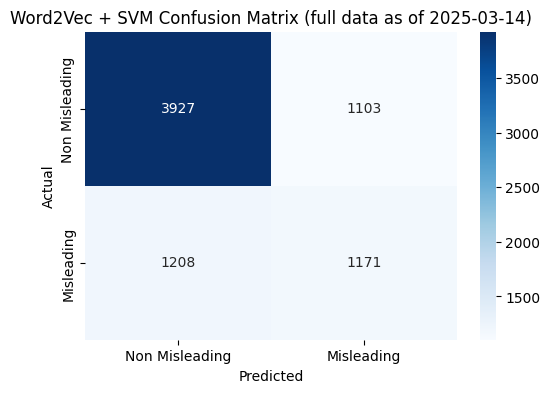

Accuracy: 0.6399
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73      5030
           1       0.44      0.46      0.45      2379

    accuracy                           0.64      7409
   macro avg       0.59      0.59      0.59      7409
weighted avg       0.64      0.64      0.64      7409

F1 Score: 45.04%
Time taken to vectorize and predict: 37.14 seconds


In [10]:
# Train a Word2Vec model on the text data
word2vec_model = Word2Vec(sentences=preproced_dict['X'], vector_size=256, window=5, min_count=2, workers=-1)

# Function to convert a tweet into a vector by averaging word embeddings
def vectorize_text(tokens, model, vector_size=256):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)  # Handle empty cases

# Convert all tweets into numerical vectors
start_time = time.time()
X_vectors = np.array([vectorize_text(tokens, word2vec_model) for tokens in preproced_dict['X']])
end_time = time.time()
vectorizer_time = end_time - start_time
print(f"Time taken to vectorize: {round(vectorizer_time, 2)} seconds")

# Split data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_vectors, preproced_dict['y'], test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# Create an SVM classifier with class balancing
svm = SVC(kernel='rbf', class_weight='balanced')
svm.fit(X_train, y_train)

# Predictions
start_time = time.time()
y_pred = svm.predict(X_test)
end_time = time.time()
predict_time = end_time - start_time
print(f"Time taken to predict: {round(predict_time, 2)} seconds")

# Evaluate performance
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Misleading", "Misleading"], yticklabels=["Non Misleading", "Misleading"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Word2Vec + SVM Confusion Matrix (full data as of 2025-03-14)')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
print(f"Time taken to vectorize and predict: {round(vectorizer_time + predict_time, 2)} seconds")

#### BoW + CatBoost

Time taken to vectorize: 0.62 seconds
Time taken to predict: 0.01 seconds


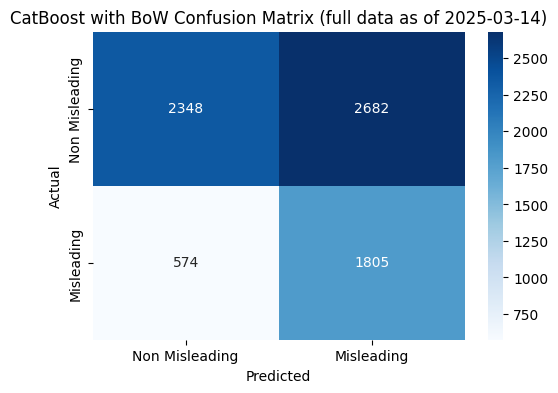


Classification Report for CatBoost with BoW:
              precision    recall  f1-score   support

           0       0.80      0.47      0.59      5030
           1       0.40      0.76      0.53      2379

    accuracy                           0.56      7409
   macro avg       0.60      0.61      0.56      7409
weighted avg       0.67      0.56      0.57      7409

Time taken to vectorize and predict: 0.63 seconds


In [19]:
# Create BoW features
bow_vectorizer = CountVectorizer(max_features=5000)

start_time = time.time()
X_bow = bow_vectorizer.fit_transform([' '.join(tokens) for tokens in preproced_dict['X']])
end_time = time.time()
vectorizer_time = end_time - start_time
print(f"Time taken to vectorize: {round(vectorizer_time, 2)} seconds")

# Split data
X_train, X_temp_bow, y_train, y_temp_bow = train_test_split(X_bow, preproced_dict['y'], test_size=0.25, random_state=42)
X_val, X_test_bow, y_val, y_test_bow = train_test_split(X_temp_bow, y_temp_bow, test_size=0.6, random_state=42)

# Initialize and train CatBoost
catboost_bow = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=False,
    auto_class_weights='Balanced',
    random_seed=42
)

catboost_bow.fit(X_train, y_train)

# Make predictions
start_time = time.time()

y_pred_bow = catboost_bow.predict(X_test_bow)
end_time = time.time()
predict_time = end_time - start_time
print(f"Time taken to predict: {round(predict_time, 2)} seconds")

# Calculate metrics
accuracy_bow = accuracy_score(y_test_bow, y_pred_bow)
precision_bow = precision_score(y_test_bow, y_pred_bow, pos_label=1)
recall_bow = recall_score(y_test_bow, y_pred_bow, pos_label=1)
f1_bow = f1_score(y_test_bow, y_pred_bow, pos_label=1)

# Plot confusion matrix
cm_bow = confusion_matrix(y_test_bow, y_pred_bow)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Misleading", "Misleading"], yticklabels=["Non Misleading", "Misleading"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost with BoW Confusion Matrix (full data as of 2025-03-14)')
plt.show()

# Print classification report
print("\nClassification Report for CatBoost with BoW:")
print(classification_report(y_test_bow, y_pred_bow))
print(f"Time taken to vectorize and predict: {round(vectorizer_time + predict_time, 2)} seconds")

# # Add results to tracking
# results.append({
#     "Model Name": "CatBoost + BoW",
#     "Accuracy": accuracy_bow * 100,
#     "Precision": precision_bow * 100,
#     "Recall": recall_bow * 100,
#     "F1-Score": f1_bow * 100
# })


#### TF-IDF + CatBoost

Time taken to vectorize: 0.56 seconds
Time taken to predict: 0.03 seconds


/Users/rj/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


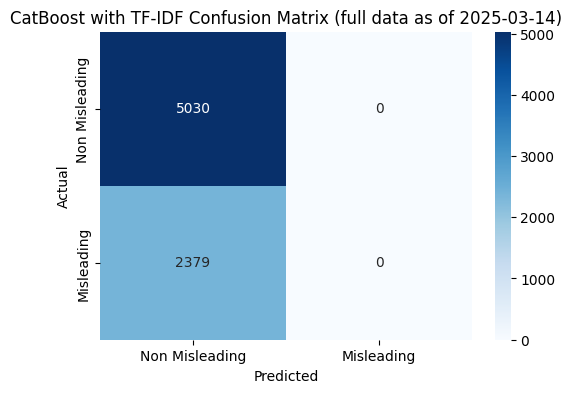


Classification Report for CatBoost with TF-IDF:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      5030
           1       0.00      0.00      0.00      2379

    accuracy                           0.68      7409
   macro avg       0.34      0.50      0.40      7409
weighted avg       0.46      0.68      0.55      7409

Time taken to vectorize and predict: 0.59 seconds


/Users/rj/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rj/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rj/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
vectorizer2 = TfidfVectorizer()

start_time = time.time()
X_tfidf = vectorizer2.fit_transform([" ".join(tweet) for tweet in preproced_dict['X']])
end_time = time.time()
vectorizer_time = end_time - start_time
print(f"Time taken to vectorize: {round(vectorizer_time, 2)} seconds")

X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(X_tfidf, preproced_dict['y'], test_size=0.25, random_state=42)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(X_temp_tfidf, y_temp_tfidf, test_size=0.6, random_state=42)

# Initialize and train CatBoost with TF-IDF features
catboost_tfidf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6, 
    loss_function='Logloss',
    verbose=False,
    auto_class_weights='Balanced',
    random_seed=42
)

catboost_tfidf.fit(X_train, y_train)

# Make predictions
start_time = time.time()
y_pred_tfidf = catboost_tfidf.predict(X_test_tfidf)
end_time = time.time()
predict_time = end_time - start_time
print(f"Time taken to predict: {round(predict_time, 2)} seconds")

# Calculate metrics
accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
precision_tfidf = precision_score(y_test_tfidf, y_pred_tfidf, pos_label=1)
recall_tfidf = recall_score(y_test_tfidf, y_pred_tfidf, pos_label=1)
f1_tfidf = f1_score(y_test_tfidf, y_pred_tfidf, pos_label=1)

# Plot confusion matrix
cm_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Misleading", "Misleading"], yticklabels=["Non Misleading", "Misleading"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost with TF-IDF Confusion Matrix (full data as of 2025-03-14)')
plt.show()

print("\nClassification Report for CatBoost with TF-IDF:")
print(classification_report(y_test_tfidf, y_pred_tfidf))
print(f"Time taken to vectorize and predict: {round(vectorizer_time + predict_time, 2)} seconds")


#### Word2Vec + CatBoost

Time taken to vectorize: 1.51 seconds
Time taken to predict: 0.01 seconds


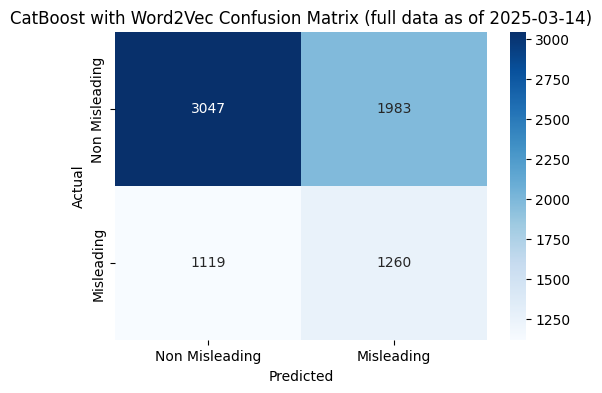


Classification Report for CatBoost with Word2Vec:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      5030
           1       0.39      0.53      0.45      2379

    accuracy                           0.58      7409
   macro avg       0.56      0.57      0.56      7409
weighted avg       0.62      0.58      0.59      7409

Time taken to vectorize and predict: 1.52 seconds


In [20]:
# Train a Word2Vec model on the text data
word2vec_model = Word2Vec(sentences=preproced_dict['X'], vector_size=256, window=5, min_count=2, workers=-1)

# Function to convert a tweet into a vector by averaging word embeddings
def vectorize_text(tokens, model, vector_size=256):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)  # Handle empty cases

# Convert all tweets into numerical vectors
start_time = time.time()
X_vectors = np.array([vectorize_text(tokens, word2vec_model) for tokens in preproced_dict['X']])
end_time = time.time()
vectorizer_time = end_time - start_time
print(f"Time taken to vectorize: {round(vectorizer_time, 2)} seconds")

# Split data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_vectors, preproced_dict['y'], test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# Initialize and train CatBoost with Word2Vec features
catboost_w2v = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=False,
    auto_class_weights='Balanced',
    random_seed=42
)

catboost_w2v.fit(X_train, y_train)

# Make predictions
start_time = time.time()
y_pred_w2v = catboost_w2v.predict(X_test)
end_time = time.time()
predict_time = end_time - start_time
print(f"Time taken to predict: {round(predict_time, 2)} seconds")

# Calculate metrics
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
precision_w2v = precision_score(y_test, y_pred_w2v, pos_label=1)
recall_w2v = recall_score(y_test, y_pred_w2v, pos_label=1)
f1_w2v = f1_score(y_test, y_pred_w2v, pos_label=1)

# Plot confusion matrix
cm_w2v = confusion_matrix(y_test, y_pred_w2v)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Misleading", "Misleading"], yticklabels=["Non Misleading", "Misleading"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost with Word2Vec Confusion Matrix (full data as of 2025-03-14)')
plt.show()

print("\nClassification Report for CatBoost with Word2Vec:")
print(classification_report(y_test, y_pred_w2v))
print(f"Time taken to vectorize and predict: {round(vectorizer_time + predict_time, 2)} seconds")
